In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from warnings import simplefilter,filterwarnings
from keras.models import Sequential, load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.utils import plot_model
import matplotlib.ticker as ticker
from keras.optimizers import Adam
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics
import keras.backend as K
import tensorflow as tf
import seaborn as sns
from experta import *
import pandas as pd
import numpy as np
import scipy.io
import pickle
import random
import math
import csv
import glob
import sys
import gc
import os
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# data_path = '/content/drive/My Drive/Colab Notebooks/Tasks/Disease prediction based on human activity recognition using smartphones/DataSet'
# code_path = '/content/drive/My Drive/Colab Notebooks/Tasks/Disease prediction based on human activity recognition using smartphones/Codes'
# results_path = '/content/drive/My Drive/Colab Notebooks/Tasks/Disease prediction based on human activity recognition using smartphones/Results'

data_path = "C:\\Users\\user\\Python_Anaconda\\task\\06\\DataSet"
results_path = "C:\\Users\\user\\Python_Anaconda\\task\\06\\Results"
model_info_path = os.path.join(results_path,'model info')
images_path = os.path.join(results_path, "images")

In [19]:
def save_object(obj, filename,path):
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()
    
def load_object(filename,path):
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [4]:
train = pd.read_csv(os.path.join(data_path,"train.csv"))
test = pd.read_csv(os.path.join(data_path,"test.csv"))

# Activity_map = {'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}
# train['Activity'] = train['Activity'].map(Activity_map)
# test['Activity'] = test['Activity'].map(Activity_map)
train.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING


In [5]:
X_train = train.drop('Activity', axis=1)
X_test = test.drop('Activity', axis=1)

y_train = np.array(train['Activity'].tolist())
y_test = np.array(test['Activity'].tolist())

print("X_train Shape : ", X_train.shape, ", Y_train Shape", y_train.shape)
print("X_test Shape : ", X_test.shape, ", Y_test Shape", y_test.shape)

X_train Shape :  (7352, 562) , Y_train Shape (7352,)
X_test Shape :  (2947, 562) , Y_test Shape (2947,)


In [18]:
num_classes = len(set(y_test))  # Number of classes
print(num_classes)

6


In [7]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_encoded = to_categorical(y_train_encoded, num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes)

num_features = X_train.shape[1]
timesteps = 1

X_train_reshaped = X_train.values.reshape(-1, timesteps, num_features)
X_test_reshaped = X_test.values.reshape(-1, timesteps, num_features)

In [20]:
save_object(label_encoder, "label_encoder",results_path)

In [8]:
def plot_history(history, title, images_path):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.savefig("{} .png".format(os.path.join(images_path , "history")))
    plt.savefig(os.path.join(images_path, title + '.svg'), format='svg')
    plt.legend()

In [9]:
model_name = "CNN_Network_"
model = Sequential()
model.add(Reshape((timesteps, num_features), input_shape=(timesteps, num_features)))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-5, decay_steps=10000, decay_rate=0.9)
model.compile(optimizer = Adam(learning_rate=lr_schedule), loss = "categorical_crossentropy", metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.load_weights(os.path.join(model_info_path, model_name+'.best.hdf5'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 562)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 128)            359808    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                5

In [10]:
plot_model(model, to_file= os.path.join(model_info_path, model_name+'.png'), show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [11]:
class GarbageCollectorCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

filepath = os.path.join(model_info_path, model_name+'.best.hdf5')
history_logger = CSVLogger(os.path.join(model_info_path,'History.csv'), separator=",", append=True)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list = [GarbageCollectorCallback(), checkpoint, es, history_logger]

In [12]:
history = model.fit(X_train_reshaped, y_train_encoded, epochs=500, batch_size=8, validation_split=0.2, verbose=1, shuffle=False, callbacks=callbacks_list)
model.save(os.path.join(model_info_path, model_name+".h5"))
# load_model(filepath=os.path.join(model_info_path ,model_name+".h5"))

Epoch 1/500
736/736 [==============================] - 3s 3ms/step - loss: 1.7270 - accuracy: 0.2979 - val_loss: 1.6613 - val_accuracy: 0.4602
Epoch 2/500
736/736 [==============================] - 2s 3ms/step - loss: 1.6441 - accuracy: 0.3527 - val_loss: 1.5917 - val_accuracy: 0.4997
Epoch 3/500
736/736 [==============================] - 2s 3ms/step - loss: 1.5762 - accuracy: 0.4244 - val_loss: 1.5198 - val_accuracy: 0.5010
Epoch 4/500
736/736 [==============================] - 3s 3ms/step - loss: 1.5063 - accuracy: 0.4656 - val_loss: 1.4505 - val_accuracy: 0.5003
Epoch 5/500
736/736 [==============================] - 2s 3ms/step - loss: 1.4339 - accuracy: 0.4799 - val_loss: 1.3805 - val_accuracy: 0.5024
Epoch 6/500
736/736 [==============================] - 3s 3ms/step - loss: 1.3616 - accuracy: 0.4926 - val_loss: 1.3079 - val_accuracy: 0.5085
Epoch 7/500
736/736 [==============================] - 2s 3ms/step - loss: 1.2911 - accuracy: 0.5018 - val_loss: 1.2382 - val_accuracy: 0.5173

Epoch 58/500
736/736 [==============================] - 2s 3ms/step - loss: 0.1902 - accuracy: 0.9471 - val_loss: 0.2625 - val_accuracy: 0.9252
Epoch 59/500
736/736 [==============================] - 3s 3ms/step - loss: 0.1849 - accuracy: 0.9475 - val_loss: 0.2585 - val_accuracy: 0.9252
Epoch 60/500
736/736 [==============================] - 3s 3ms/step - loss: 0.1799 - accuracy: 0.9478 - val_loss: 0.2550 - val_accuracy: 0.9245
Epoch 61/500
736/736 [==============================] - 2s 3ms/step - loss: 0.1751 - accuracy: 0.9493 - val_loss: 0.2521 - val_accuracy: 0.9252
Epoch 62/500
736/736 [==============================] - 2s 3ms/step - loss: 0.1707 - accuracy: 0.9514 - val_loss: 0.2487 - val_accuracy: 0.9245
Epoch 63/500
736/736 [==============================] - 2s 3ms/step - loss: 0.1663 - accuracy: 0.9529 - val_loss: 0.2453 - val_accuracy: 0.9252
Epoch 64/500
736/736 [==============================] - 2s 3ms/step - loss: 0.1624 - accuracy: 0.9539 - val_loss: 0.2424 - val_accuracy:

Epoch 115/500
736/736 [==============================] - 3s 3ms/step - loss: 0.0775 - accuracy: 0.9757 - val_loss: 0.1803 - val_accuracy: 0.9347
Epoch 116/500
736/736 [==============================] - 3s 3ms/step - loss: 0.0768 - accuracy: 0.9759 - val_loss: 0.1796 - val_accuracy: 0.9347
Epoch 117/500
736/736 [==============================] - 3s 4ms/step - loss: 0.0761 - accuracy: 0.9759 - val_loss: 0.1790 - val_accuracy: 0.9347
Epoch 118/500
736/736 [==============================] - 3s 3ms/step - loss: 0.0754 - accuracy: 0.9759 - val_loss: 0.1785 - val_accuracy: 0.9347
Epoch 119/500
736/736 [==============================] - 2s 3ms/step - loss: 0.0748 - accuracy: 0.9760 - val_loss: 0.1779 - val_accuracy: 0.9361
Epoch 120/500
736/736 [==============================] - 2s 3ms/step - loss: 0.0742 - accuracy: 0.9767 - val_loss: 0.1776 - val_accuracy: 0.9368
Epoch 121/500
736/736 [==============================] - 3s 3ms/step - loss: 0.0736 - accuracy: 0.9772 - val_loss: 0.1770 - val_ac

736/736 [==============================] - 2s 3ms/step - loss: 0.0450 - accuracy: 0.9869 - val_loss: 0.1510 - val_accuracy: 0.9375
Epoch 228/500
736/736 [==============================] - 3s 4ms/step - loss: 0.0449 - accuracy: 0.9869 - val_loss: 0.1508 - val_accuracy: 0.9375
Epoch 229/500
736/736 [==============================] - 2s 3ms/step - loss: 0.0448 - accuracy: 0.9871 - val_loss: 0.1507 - val_accuracy: 0.9375
Epoch 230/500
736/736 [==============================] - 3s 4ms/step - loss: 0.0446 - accuracy: 0.9872 - val_loss: 0.1506 - val_accuracy: 0.9375
Epoch 231/500
736/736 [==============================] - 3s 3ms/step - loss: 0.0445 - accuracy: 0.9872 - val_loss: 0.1505 - val_accuracy: 0.9375
Epoch 232/500
736/736 [==============================] - 3s 3ms/step - loss: 0.0444 - accuracy: 0.9872 - val_loss: 0.1504 - val_accuracy: 0.9375
Epoch 233/500
736/736 [==============================] - 3s 3ms/step - loss: 0.0443 - accuracy: 0.9874 - val_loss: 0.1502 - val_accuracy: 0.9375

736/736 [==============================] - 2s 3ms/step - loss: 0.0370 - accuracy: 0.9896 - val_loss: 0.1419 - val_accuracy: 0.9443
Epoch 340/500
736/736 [==============================] - 2s 3ms/step - loss: 0.0370 - accuracy: 0.9896 - val_loss: 0.1420 - val_accuracy: 0.9443
Epoch 341/500
736/736 [==============================] - 3s 3ms/step - loss: 0.0370 - accuracy: 0.9896 - val_loss: 0.1419 - val_accuracy: 0.9443
Epoch 342/500
736/736 [==============================] - 3s 4ms/step - loss: 0.0369 - accuracy: 0.9896 - val_loss: 0.1419 - val_accuracy: 0.9443
Epoch 343/500
736/736 [==============================] - 3s 4ms/step - loss: 0.0369 - accuracy: 0.9896 - val_loss: 0.1418 - val_accuracy: 0.9443
Epoch 344/500
736/736 [==============================] - 2s 3ms/step - loss: 0.0368 - accuracy: 0.9896 - val_loss: 0.1419 - val_accuracy: 0.9443
Epoch 345/500
736/736 [==============================] - 2s 3ms/step - loss: 0.0368 - accuracy: 0.9898 - val_loss: 0.1418 - val_accuracy: 0.9443

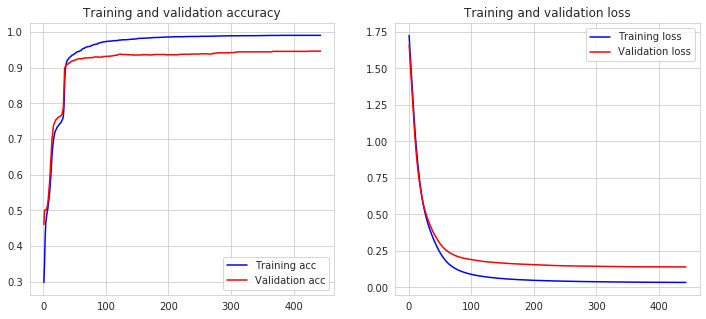

In [13]:
plot_history(history, "Accuracy", images_path)

In [22]:
y_pred = model.predict(X_test_reshaped, verbose=0)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_encoded, axis=1)
classification_rep = classification_report(y_test_labels, y_pred_labels)
classes_number = [0, 1, 2, 3, 4, 5]
classes = label_encoder.inverse_transform(classes_number)
print(list(zip(classes, classes_number)))
print(classification_rep)

[('LAYING', 0), ('SITTING', 1), ('STANDING', 2), ('WALKING', 3), ('WALKING_DOWNSTAIRS', 4), ('WALKING_UPSTAIRS', 5)]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       272
           1       0.99      0.96      0.97       240
           2       0.96      0.99      0.98       272
           3       0.94      0.96      0.95       245
           4       0.98      0.78      0.87       223
           5       0.85      1.00      0.92       248

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.96      0.95      0.95      1500



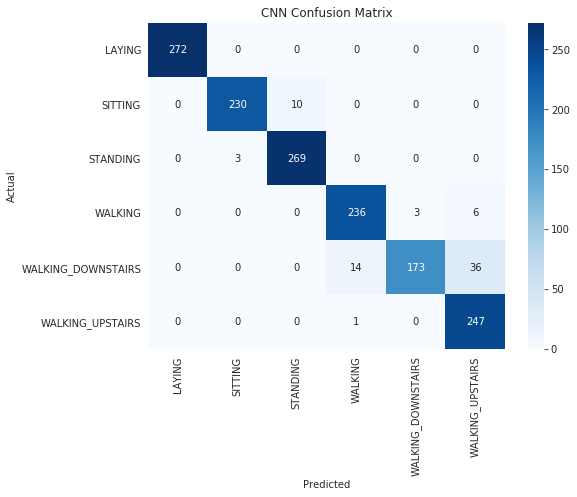

In [23]:
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN Confusion Matrix')
plt.savefig("{} .png".format(os.path.join(images_path , 'CNN Confusion Matrix')))
plt.show()

In [16]:
import subprocess
requirements_file = os.path.join(results_path, 'requirements.txt')
subprocess.run(['pip', 'freeze'], stdout=open(requirements_file, 'w'))

CompletedProcess(args=['pip', 'freeze'], returncode=0)